# Wrangle and Analyze WeRateDogs Twitter data

In [1]:
# Import libraries and packages
import pandas as pd
pd.set_option('max_colwidth', 500) # To view the whole comlumn cell(To avoid text being omitted)
# pd.options.display.max_rows = 500 # To view upto 100 rows.
# pd.set_option('display.max_columns', 500) # To avoid columns omitted
# pd.describe_option("display.max_rows", 1000) # To check each row (To avoid rows being omitted)
import numpy as np
import requests
import os
import tweepy # To query Twitter's API for additional data beyond the data included in the WeRateDogs Twitter archive
import json
import matplotlib.pyplot as plt
%matplotlib inline
import re
# from IPython.display import display
import sys
import seaborn as sns

#  1. Gather

## 1.1 twitter_archive file
Twitter archive file from Udacity

In [2]:
# Read twitter-archive csv file and create a dataframe
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

## 1.2 predictions(Image-predictions)
Image-predictions from specified web

In [3]:
# Download dog breeds prediction tsv file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open(os.path.join(os.getcwd(), url.split('/')[-1]), mode = 'wb') as file:
          file.write(response.content)
          
# Create a dataframe from tsv file
predictions = pd.read_csv("image-predictions.tsv", sep='\t')
predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


### Columns Definition
p1: the algorithm's #1 prediction for the image in the tweet  
p1_conf: how confident the algorithm is in its #1 prediction
p1_dog: whether or not the #1 prediction is a breed of dog  

Above explantions are applied to p2, p3 as well.

# 1.3 tweet_json
Through Tweepy(Python library for accessing the Twitter API.)

In [4]:
# Make a list for 'tweet_id' to access API
tweet_json = list(twitter_archive['tweet_id'])

In [5]:
# My own info for Tweepy Authentication I deleted below 4 rows before uploading

consumer_key = 
consumer_secret = 
access_token = 
access_secret = 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler = auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [6]:
# Just in case for id_errors
id_errors = []

def get_tweets(screen_name):
    # Get the most recent new 200(max that we can get) tweets
    recent_tweets = api.user_timeline(screen_name = screen_name, count = 200)
    
    # Add 'recent_tweets' to 'tweets_total'
    tweets_total = []
    tweets_total.extend(recent_tweets)
    
    # Save the id of oldest tweet less one
    oldest = tweets_total[-1].id - 1  # tweets_total 어떤 구조지?
    
    # Get all the tweets from recent_tweets
    while len(recent_tweets) > 0:
        try:
            # All subsequent requests use the max_id param to prevent duplicates
            recent_tweets = api.user_timeline(screen_name = screen_name, count = 200, max_id = oldest)
            
            # Save most recent tweets
            tweets_total.extend(recent_tweets)
            
            # Update the id of the oldest tweet less one
            oldest = tweets_total[-1].id - 1
            
            print("... {} tweets downloaded so far ".format(len(tweets_total)))
            
        except Exception as e:
                print(recent_tweets.id_str + " : " + str(e))
                id_errors.append(recent_tweets)
                continue
                
    # Transform the tweepy tweets into a 2D array that will populate the txt file
    outtweets = [[tweet.id_str, tweet.retweet_count, tweet.favorite_count] for tweet in tweets_total]
    
    # Transform the array to DataFrame
    df = pd.DataFrame.from_dict(outtweets)
    
    # Write text file
    df.to_csv('tweet_json.txt', header = True, index = None, sep = ' ', mode = 'w')
    print('tweet_json.txt file is created successfully')

if __name__ == '__main__':
    
    # Pass the username of the account we need
    get_tweets("dog_rates")

... 400 tweets downloaded so far 
... 600 tweets downloaded so far 
... 800 tweets downloaded so far 
... 1000 tweets downloaded so far 
... 1200 tweets downloaded so far 
... 1399 tweets downloaded so far 
... 1598 tweets downloaded so far 
... 1797 tweets downloaded so far 
... 1997 tweets downloaded so far 
... 2197 tweets downloaded so far 
... 2397 tweets downloaded so far 
... 2595 tweets downloaded so far 
... 2795 tweets downloaded so far 
... 2993 tweets downloaded so far 
... 3192 tweets downloaded so far 
... 3234 tweets downloaded so far 
... 3234 tweets downloaded so far 
tweet_json.txt file is created successfully


In [7]:
# Transform the txt file to DataFrame
tweet_json = pd.read_csv('tweet_json.txt',sep=' ')

# Rename the column names 
tweet_json.columns =["tweet_id","retweet_count","favorite_count"]
tweet_json.head(1)

,tweet_id,retweet_count,favorite_count
0,1005145988871475200,1,177


#  2. Access

## 2.1 twittter_archive

Check there are __duplicated rows__ or not

In [8]:
twitter_archive[twitter_archive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Check there are duplicated __'tweet_id'__ or not(There shouldn't be, because this is an unique value for each rating.)

In [9]:
twitter_archive[twitter_archive['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Check there are duplicated __'timestamp'__ or not(There shouldn't be, because this is an unique value for each rating.)

In [10]:
twitter_archive[twitter_archive['timestamp'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Check there is duplicated __'text'__ or not(There shouldn't be, because this is an unique value for each rating.)

In [11]:
twitter_archive[twitter_archive['text'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Check there are duplicated __'expanded_urls'__ or not(There shouldn't be, because this is an unique value for each rating.)

In [12]:
twitter_archive[twitter_archive['expanded_urls'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6",NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,NaN,NaN,NaN,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1",12,10,Sierra,None,None,pupper,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
126,868552278524837888,NaN,NaN,2017-05-27 19:39:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Cooper. His expression is the same wet or dry. Absolute 12/10 but Coop desperately requests your help\n\nhttps://t.co/ZMTE4Mr69f https://t.co/7RyeXTYLNi,NaN,NaN,NaN,"https://www.gofundme.com/3ti3nps,https://twitter.com/dog_rates/status/868552278524837888/photo/1,https://twitter.com/dog_rates/status/868552278524837888/photo/1",12,10,Cooper,None,None,None,None
135,866450705531457537,NaN,NaN,2017-05-22 00:28:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,10,Jamesy,None,None,pupper,None
136,866334964761202691,NaN,NaN,2017-05-21 16:48:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.co/W86h5dgR6c,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/866334964761202691/photo/1,https://twitter.com/dog_rates/status/866334964761202691/photo/1",12,10,Coco,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:

### There are two kinds of 'expanded_urls' duplicated.  
__The first__ is 'expanded_urls' is NaN and the second is 'expanded_urls' != NaN.  
'expanded_urls' == NaN type can be made up by putting tweet_id after https://twitter.com/dog_rates/status/  
<font color = red> This led by the Project Motivation.  
tweet_id is the last part of the tweet URL after "status/"  </font>


__The second__ is  'expanded_urls' is __not__ NaN. If these are not retweets, they should be deleted. Plus, the duplicates are not by time ordered. I need to make it time ordered first and check the duplicates are retweets or not.

### 2.1.1 Make up NaN 'expanded_urls' with 'tweet_id'

In [13]:
twitter_archive[twitter_archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


### 2.1.2 Delete not retweeted but duplicated data  'expanded_urls' 

Sort the twitter_archive dataframe by 'timestamp' first and name it __twitter_archive_t_o__. t_o stands for Time Ordered.

In [14]:
twitter_archive_t_o = twitter_archive.sort_values(by = ['timestamp'])
twitter_archive_t_o = twitter_archive_t_o.reset_index(drop = True) # Reset index to check retweet(Retweet is made later than original)
twitter_archive_t_o.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None
1,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
3,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
4,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None


In [15]:
to_ex_dupl = twitter_archive_t_o[twitter_archive_t_o['expanded_urls'].duplicated()]
to_ex_dupl[to_ex_dupl['expanded_urls'].notnull()] # 'expanded_urls' excluding NaNs

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1312,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
1332,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,None,None,None,None
1343,747242308580548608,NaN,NaN,2016-06-27 01:37:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://…,7.047611e+17,4.196984e+09,2016-03-01 20:11:59 +0000,"https://twitter.com/dog_rates/status/704761120771465216/photo/1,https://twitter.com/dog_rates/status/704761120771465216/photo/1",13,10,None,None,None,pupper,None
1418,753298634498793472,NaN,NaN,2016-07-13 18:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Carly. She's actually 2 dogs fused together. Very innovative. Probably has superpowers. 12/10 for double dog https:/…,6.815232e+17,4.196984e+09,2015-12-28 17:12:42 +0000,https://twitter.com/dog_rates/status/681523177663676416/photo/1,12,10,Carly,None,None,None,None
1495,763167063695355904,NaN,NaN,2016-08-10 00:16:21 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,6.732953e+17,4.196984e+09,2015-12-06 00:17:55 +0000,https://twitter.com/dog_rates/status/673295268553605120/photo/1,8,10,Eve,None,None,pupper,None
1514,766864461642756096,NaN,NaN,2016-08-20 05:08:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs... this is a Taiwanese Guide Walrus. Im getting real heckin tired of this. Please send dogs. 10/10 https:/…,7.599238e+17,4.196984e+09,2016-08-01 01:28:46 +0000,https://twitter.com/dog_rates/status/759923798737051648/photo/1,10,10,None,None,None,None,None
1522,768554158521745409,NaN,NaN,2016-08-24 21:02:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Nollie. She's waving at you. If you don't wave back you're a monster. She's also portable as hell. 12/10 https://t.c…,7.399792e+17,4.196984e+09,2016-06-07 00:36:02 +0000,https://twitter.com/dog_rates/status/739979191639244800/photo/1,12,10,Nollie,None,None,None,None
1526,768909767477751808,NaN,NaN,2016-08-25 20:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: When it's Janet from accounting's birthday but you can't eat the cake cuz it's chocolate. 10/10 hang in there pupper https:/…,7.001438e+17,4.196984e+09,2016-02-18 02:24:13 +0000,https://twitter.com/dog_rates/status/700143752053182464/photo/1,10,10,None,None,None,pupper,None
1537,770743923962707968,NaN,NaN,2016-08-30 22:04:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Here's a doggo blowing bubbles. It's downright legendar

Only one row with tweet id: 791774931465953280 is searched that is not a retweet. So let's check this.

In [16]:
twitter_archive[twitter_archive['tweet_id'] == 791774931465953280]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
657,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None


In [17]:
twitter_archive[twitter_archive['expanded_urls'] == 'https://vine.co/v/ea0OwvPTx9l'] # Search the rows with above 'expanded_url'

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
657,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None


For sure, 'WeRateDogs' rated twice for this url. One of duplicates must be deleted.

### 2.1.3 +0000 in every 'timestamp' should be removed.

Check how many 'timestamp' have +0000 within, this is useless, should be removed. 

In [18]:
len(twitter_archive['timestamp'].str.contains('+0000', regex = False)) /  len(twitter_archive) # Yes all timestamp has extra '+0000'

1.0

### 2.1.4 For 'source' we can categorize above 4 long sentences into 4 types
1) Twitter for iPhone 2) Vine 3) Twitter Web Client 4) TweetDeck

In [19]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### 2.1.5 Delete retweet data

In [20]:
twitter_archive[twitter_archive['text'].str.contains('RT', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
80,877316821321428993,NaN,NaN,2017-06-21 00:06:44 +0000,"<a href=""http://twitter.com/download/iphone"" re

#### 'rating_numerator' wrongly filled.

In [21]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
# I consider scores from 1 - 20 are noraml. Because WeRateDogs often rated more than 10
# However, bigger than 20 need attention
a = twitter_archive[twitter_archive['rating_numerator'] > 20]
a[['text', 'rating_numerator', 'tweet_id']]

,text,rating_numerator,tweet_id
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,855862651834028034
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,855860136149123072
290,@markhoppus 182/10,182,838150277551247360
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,835246439529840640
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,832215909146226688
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,820690176645140481
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,810984652412424192
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,786709082849828864
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,778027034220126208
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,758467244762497024


There are two types of wrongly filled.  

__The First__ rating_numerator in text is decimall like below examples.  
tweet_id 832215909146226688, 786709082849828864, 778027034220126208, 680494726643068929 : score on rating_numerator is decimal.  
Need to be replaced by the score on 'text'

__The Second__ is  confused by two  ??/??s <- ex) 13/10 and 9/11 in one tweet. like below two.  
tweet_id 835246439529840640 : 'rating_numerator' should be 13 according to the text.    
tweet_id 716439118184652801 : 'rating_numerator' should be 11 according to the text.   
These confuse 'rating_numerator' and 'rating_denominator'. So it will be a lot but need to be inspected one by one.

### 2.1.6 Check tweets that decimal value

In [23]:
# For first wrongly filled
twitter_archive[twitter_archive['text'].str.contains('\d+\.\d+', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
259,843235543001513987,NaN,NaN,2017-03-18 22:59:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1",13,10,Tycho,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1018,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746818907684614144/photo/1,13,10,None,None,None,None,None
1294,707995814724026368,NaN,NaN,2016-03-10 18:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Farfle. He lost his back legs during the Battle of Gettysburg. Goes 0-60 in 4.3 seconds (damn) 12/10 hero af https://t.co/NiQQWzIzzq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707995814724026368/photo/1,12,10,Farfle,None,None,None,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None
1768,678389028614488064,NaN,NaN,2015-12-20 01:38:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for 

'rating_numerator' should be modified by the score in 'text'

### 2.1.7 Check tweets' 'text' that have two cases of ??/?? -> Replace 'rating_numerator' and 'rating_denominator' 

In [24]:
# For Second wrongly filled
# Tweets have 2 of ??/??
twitter_archive[twitter_archive['text'].str.contains('\d+/\d+\D+\d+/\d+', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,"https://twitter.com/dog_rates/status/777684233540206592/photo/1,https://twitter.com/dog_rates/status/777684233540206592/photo/1",12,10,None,None,None,None,None
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
860,763167063695355904,NaN,NaN,2016-08-10 00:16:21 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,6.732953e+17,4.196984e+09,2015-12-06 00:17:55 +0000,https://twitter.com/dog_rates/status/673295268553605120/photo/1,8,10,Eve,None,None,pupper,None
1007,747600769478692864,NaN,NaN,2016-06-28 01:21:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747600769478692864/photo/1,https://twitter.com/dog_rates/status/747600769478692864/photo/1",10,10,Bookstore,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for 

### There are two dogs in one picture sometimes. In this case, I am putting average of theme in 'rating_numerator'
### Sometimes date is filled as ??/??
### 'rating_numerator' and 'rating_denominator' of these should be modified by the scores in 'text'

### 2.1.8 'rating_denominator' wrongly filled
Let's check 'rating_denominator' column. Basically all denominators should be 10. So I would like to check the denominators which are not 10.

In [25]:
# pd.set_option('max_colwidth', 999)
a = twitter_archive[twitter_archive['rating_denominator'] != 10]
a[['text', 'rating_denominator']]

,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50


index
313 분모 -> 10으로 바뀌어야
342 행 삭제


### 2.1.9 'name' wrongly filled

In [26]:
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
an              7
Toby            7
Bailey          7
Buddy           7
Daisy           7
Rusty           6
Bella           6
Scout           6
Oscar           6
Leo             6
Milo            6
Jax             6
Stanley         6
Jack            6
Koda            6
Dave            6
Sammy           5
             ... 
Gunner          1
Sully           1
Edd             1
General         1
Duddles         1
Noosh           1
Milky           1
Mo              1
Christoper      1
Leonard         1
Evy             1
Brandy          1
Genevieve       1
Kirk            1
Lucky           1
Jazz            1
Lilli           1
Shiloh          1
Tupawc          1
Remus           1
light           1
Dotsy           1
Grizzie         1
Bonaparte       1
Clarkus   

#### It is hard to believe name of dog is 'a' & 'an' & 'the' & 'by' and so on. It is doubtable if the name is lowercase.

In [27]:
# Sort the lowercase dog names
twitter_archive[twitter_archive['name'] == twitter_archive['name'].str.lower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog

if the name in 'name's is lowercase, it would better to be replaced as None.

### 2.1.10 Merge into 'dog_breeds' and remove 4('doggo', 'floofer', 'pupper', 'puppo' ) columns

In [28]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The columns 'doggo', 'floofer', 'pupper', 'puppo' are breeds of dogs. So This should be merged into one column.

### 2.1.11 datatype of 'tweet_id' should be string. It is number but we don't calculate with that.
### 2.1.12 datatype of 'source' should be category. It has only 4 options.
### 2.1.13 datatype of 'rating_numerator' should be float, because sometimes it has decimal.

## 2.2 predictions

Check there are __duplicated rows__ or not

In [29]:
predictions[predictions.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


Check __'tweet_id'__ are duplicated rows or not

In [30]:
predictions[predictions['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


Check __'jpg_url'__ are duplicated rows or not

In [31]:
predictions[predictions['jpg_url'].duplicated()].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


Let's see the duplicates with originals

In [32]:
predictions[(predictions['jpg_url'] == 'https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg') |
            (predictions['jpg_url'] == 'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg') |
            (predictions['jpg_url'] == 'https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg') |
            (predictions['jpg_url'] == 'https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg') |
            (predictions['jpg_url'] == 'https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg') 
           ].sort_values(by = 'jpg_url')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
224,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
587,679062614270468097,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1188,739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


Yes, duplicates are completely identical with originals. Duplicates would be retweets. But only with 'prediction' dataframe, it is impossible to know which are retweets. So I would keep and after merging with 'twitter_archive' check again.

If prediction #2 is bigger than or equal to prediction #1 or prediction #3 is bigger than or equal to prediction #2, it doesn't make sense.

So I check below two cases.

In [33]:
predictions[predictions['p1_conf'] <= predictions['p2_conf']] # It is good to go

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [34]:
predictions[predictions['p2_conf'] <= predictions['p3_conf']]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [35]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 2.2.1 datatype of 'tweet_id' should be string

## 2.3 tweet_json

Check there are duplicated rows or not

In [36]:
tweet_json[tweet_json.duplicated()]

,tweet_id,retweet_count,favorite_count


In [37]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 3 columns):
tweet_id          3234 non-null int64
retweet_count     3234 non-null int64
favorite_count    3234 non-null int64
dtypes: int64(3)
memory usage: 75.9 KB


### 2.3.1 datatype of  tweet_id should be string

### 2.3.2 Consolidate 3 files('twitter_archive', 'predictions', 'tweet_ids')

In [38]:
predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
663,682662431982772225,https://pbs.twimg.com/media/CXlN1-EWMAQdwXK.jpg,1,beagle,0.413824,True,Cardigan,0.263553,True,basset,0.167618,True


In [39]:
predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
web_site                      19
Maltese_dog                   18
beagle                        18
Eskimo_dog                    18
teddy                         18
Shetland_sheepdog             18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

Except Arctic_fox, Loafer, Angora, American_black_bear, African_crocodile, Madagascar_cat, and Egyptian_cat, all non-dog-name are started with lowercase.

# 2.4 Summary of Quality issues
For 'twitter_archive'  
1) Delete retweet rows  
2) Make up NaN 'expanded_urls' with 'tweet_id'  
3) Delete not retweeted duplicated 'expanded_urls'  
4) +0000 in every 'timestamp' should be removed.  
5) For 'source' we can categorize above 4 long sentences into 4 types  
6) Check tweets that decimal value  
7) Check tweets' 'text' that have two cases of ??/?? -	> Replace 'rating_numerator' and 'rating_denominator'  
8) datatype of 'tweet_id' should be string. It is number but we don't calculate with that  
9) datatype of 'source' should be category. It has only 4 options  

For 'predicitons'    
10) datatype of 'tweet_id' should be string  

For 'tweet_json'  
11) datatype of 'tweet_id' should be string


# 2.5 Summary of Tidiness issues
For 'twitter_archive'  
1) Merge into 'dog_breeds' and remove 4('doggo', 'floofer', 'pupper', 'puppo' ) columns

# 3. Clean
Let's start from making clean data

In [40]:
twitter_archive_clean = twitter_archive.copy()
predictions_clean = predictions.copy()
tweet_json_clean = tweet_json.copy() 

## 3.1 Quality issues

## For 'twitter_archive'  

__Define__

1) Delete retweet rows 

__Code__

In [41]:
# Store Retweeted data in 'ReTweet' list
ReTweet = twitter_archive_clean[twitter_archive_clean['text'].str.contains('RT', regex = True)].index
ReTweet = list(ReTweet)

# Drop ReTweet rows
twitter_archive_clean.drop(ReTweet, inplace = True)

__Test__

In [42]:
twitter_archive_clean[twitter_archive_clean['text'].str.contains('RT', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## For 'twitter_archive'  

__Define__

2) Make up NaN 'expanded_urls' with 'tweet_id'

__Code__

In [43]:
twitter_archive_clean.expanded_urls.fillna(value = 'https://twitter.com/dog_rates/status/' + twitter_archive_clean['tweet_id'].astype(str) + '/photo/1', inplace = True)

__Test__

In [44]:
twitter_archive_clean[twitter_archive_clean['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__

3) Delete not retweeted but duplicated 'expanded_urls'

tweet_id: 791774931465953280 is the only one duplicated. Let's remove this row.

__Code__

In [45]:
# Remove the row of which 'tweet_id' equals to 791774931465953280
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 791774931465953280]


__Test__

In [46]:
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 791774931465953280] # There is no row with 'tweet_id' is 791774931465953280

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__

3) datatype of 'rating_numerator' should be float, because sometimes it has decimal.

__Code__

In [47]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)

__Test__

In [48]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2163 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2163 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2163 non-null object
source                        2163 non-null object
text                          2163 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2163 non-null object
rating_numerator              2163 non-null float64
rating_denominator            2163 non-null int64
name                          2163 non-null object
doggo                         2163 non-null object
floofer                       2163 non-null object
pupper                        2163 non-null object
puppo                         2163 non-null object
dtypes: float64(5), int64(2), object

__Define__  

4) +0000 in every 'timestamp' should be removed.  

__Code__

In [49]:
twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].str[:-6]

__Test__

In [50]:
twitter_archive_clean.timestamp.sample(5)

1626    2016-01-06 18:14:31
1423    2016-02-12 04:07:53
1762    2015-12-20 18:29:43
567     2016-11-25 19:55:35
2099    2015-11-28 21:34:09
Name: timestamp, dtype: object

__Define__

5) For 'source' we can categorize above 4 long sentences into 4 short names.

In [51]:
twitter_archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2034
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          87
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

__Code__

In [52]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

twitter_archive_clean['source'] = twitter_archive_clean ['source'].apply(remove_tags)

__Test__

In [53]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     2034
Vine - Make a Scene      87
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

__Define__

6) Check tweets that decimal value

__Code__

In [54]:
# Find data that has decimal values in 'text'
twitter_archive_clean[twitter_archive_clean['text'].str.contains('\d+\.\d+', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5.0,10,Bella,None,None,None,None
259,843235543001513987,NaN,NaN,2017-03-18 22:59:54,Twitter for iPhone,This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1",13.0,10,Tycho,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27.0,10,Sophie,None,None,pupper,None
1018,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37,Twitter for iPhone,Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746818907684614144/photo/1,13.0,10,None,None,None,None,None
1294,707995814724026368,NaN,NaN,2016-03-10 18:25:30,Twitter for iPhone,This is Farfle. He lost his back legs during the Battle of Gettysburg. Goes 0-60 in 4.3 seconds (damn) 12/10 hero af https://t.co/NiQQWzIzzq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707995814724026368/photo/1,12.0,10,Farfle,None,None,None,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27,Twitter for iPhone,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681340665377193984/photo/1,5.0,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26.0,10,None,None,None,None,None
1768,678389028614488064,NaN,NaN,2015-12-20 01:38:42,Twitter for iPhone,This is Bella. She just learned that her final grade in chem was a 92.49 \npoor pupper 11/10 https://t.co/auOoKuoveM,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678389028614488064/photo/1,11.0,10,Bella,None,None,pupper,None
1790,677530072887205888,NaN,NaN,2015-12-17 16:45:31,Twitter for iPhone,Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun https://t.co/DKe9DBnnHE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677530072887205888/photo/1,9.0,10,Axel,None,None,None,None


In [55]:
# Replace(Only for required replacement) rating_numerator according to the ratings in 'text'
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 883482846933004288, 'rating_numerator'] = 13.5
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 786709082849828864, 'rating_numerator'] = 9.75
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 778027034220126208, 'rating_numerator'] = 11.27
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 681340665377193984, 'rating_numerator'] = 9.5
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 680494726643068929, 'rating_numerator'] = 11.26

__Test__

In [56]:
print(twitter_archive_clean[twitter_archive_clean['tweet_id'] == 883482846933004288].rating_numerator)
print(twitter_archive_clean[twitter_archive_clean['tweet_id'] == 786709082849828864].rating_numerator)
print(twitter_archive_clean[twitter_archive_clean['tweet_id'] == 778027034220126208].rating_numerator)
print(twitter_archive_clean[twitter_archive_clean['tweet_id'] == 681340665377193984].rating_numerator)
print(twitter_archive_clean[twitter_archive_clean['tweet_id'] == 680494726643068929].rating_numerator)

45    13.5
Name: rating_numerator, dtype: float64
695    9.75
Name: rating_numerator, dtype: float64
763    11.27
Name: rating_numerator, dtype: float64
1689    9.5
Name: rating_numerator, dtype: float64
1712    11.26
Name: rating_numerator, dtype: float64


__Define__

7) For 'text' has two ??/??(? is number here), replace 'rating_numerator' and 'rating_denominator' by 'text' column

__Code__

In [57]:
# Replace ratings according to the ratings in 'text' 13, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 881633300179243008,
                          ['rating_numerator', 'rating_denominator']] = 13, 10

# Replace ratings according to the ratings in 'text' 13, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 835246439529840640,
                          ['rating_numerator', 'rating_denominator']] = 13, 10

# There are two ratings for two dogs. So put the average of them 12, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 777684233540206592,
                          ['rating_numerator', 'rating_denominator']] = 12, 10

# There are two ratings for two dogs. So put the average of them 8.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 747600769478692864,
                          ['rating_numerator', 'rating_denominator']] = 8.5, 10

# Replace ratings according to the ratings in 'text' 14, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 740373189193256964,
                          ['rating_numerator', 'rating_denominator']] = 14, 10

# Replace ratings according to the ratings in 'text' 13, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 722974582966214656,
                          ['rating_numerator', 'rating_denominator']] = 13, 10

# Replace ratings according to the ratings in 'text' 11, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 716439118184652801,
                          ['rating_numerator', 'rating_denominator']] = 11, 10

# There are two ratings for two dogs. So put the average of them 9, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 714258258790387713,
                          ['rating_numerator', 'rating_denominator']] = 9, 10

# There are two ratings for two dogs. So put the average of them 7.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 691483041324204033,
                          ['rating_numerator', 'rating_denominator']] = 7.5, 10

# There are two ratings for two dogs. So put the average of them 8, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 690400367696297985,
                          ['rating_numerator', 'rating_denominator']] = 8, 10

# There are two ratings for two dogs. So put the average of them 10.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 689835978131935233,
                          ['rating_numerator', 'rating_denominator']] = 10.5, 10

# Replace ratings according to the ratings in 'text' 10, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 682962037429899265,
                          ['rating_numerator', 'rating_denominator']] = '10', '10'

# There are two ratings for two dogs. So put the average of them 10.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 677314812125323265,
                          ['rating_numerator', 'rating_denominator']] = 10.5, 10

# There are two ratings for two dogs. So put the average of them 8.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 676191832485810177,
                          ['rating_numerator', 'rating_denominator']] = 8.5, 10

# There are two ratings for two dogs. So put the average of them 6.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 674646392044941312,
                          ['rating_numerator', 'rating_denominator']] = 6.5, 10

# There are two ratings for two dogs. So put the average of them 9.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 670434127938719744,
                          ['rating_numerator', 'rating_denominator']] = 9.5, 10

# There are two ratings for two dogs. So put the average of them 8.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 669037058363662336,
                          ['rating_numerator', 'rating_denominator']] = 8.5, 10

# There are two ratings for two dogs. So put the average of them 7, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 667544320556335104,
                          ['rating_numerator', 'rating_denominator']] = 7, 10

# There are two ratings for two dogs. So put the average of them 7.5, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 667491009379606528,
                          ['rating_numerator', 'rating_denominator']] = 7.5, 10

# Replace ratings according to the ratings in 'text' 9, 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 666287406224695296,
                          ['rating_numerator', 'rating_denominator']] = 9, 10

__Test__

In [58]:
twitter_archive_clean[twitter_archive_clean['text'].str.contains('\d+\.\d+', regex = True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.5,10,Bella,None,None,None,None
259,843235543001513987,NaN,NaN,2017-03-18 22:59:54,Twitter for iPhone,This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1",13,10,Tycho,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10,Sophie,None,None,pupper,None
1018,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37,Twitter for iPhone,Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746818907684614144/photo/1,13,10,None,None,None,None,None
1294,707995814724026368,NaN,NaN,2016-03-10 18:25:30,Twitter for iPhone,This is Farfle. He lost his back legs during the Battle of Gettysburg. Goes 0-60 in 4.3 seconds (damn) 12/10 hero af https://t.co/NiQQWzIzzq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707995814724026368/photo/1,12,10,Farfle,None,None,None,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27,Twitter for iPhone,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681340665377193984/photo/1,9.5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10,None,None,None,None,None
1768,678389028614488064,NaN,NaN,2015-12-20 01:38:42,Twitter for iPhone,This is Bella. She just learned that her final grade in chem was a 92.49 \npoor pupper 11/10 https://t.co/auOoKuoveM,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678389028614488064/photo/1,11,10,Bella,None,None,pupper,None
1790,677530072887205888,NaN,NaN,2015-12-17 16:45:31,Twitter for iPhone,Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun https://t.co/DKe9DBnnHE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677530072887205888/photo/1,9,10,Axel,None,None,None,None


__Define__

8) 'rating_denominator' wrongly filled (This is supposed to be 10)

In [59]:
# Find data 'rating_denominator' is not 10
twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,Twitter for iPhone,@docmisterio account started on 11/15/15,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832088576586297345/photo/1,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49,Twitter for iPhone,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08,Twitter for iPhone,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30,Twitter for iPhone,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60,50,a,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59,Twitter for iPhone,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44,40,None,None,None,None,None


We only need to pay attention to tweet_id = 832088576586297345, 810984652412424192. They do not include rating info in 'text'. Therefore remove these two rows.  
Others are good to go.


__Code__

In [60]:
twitter_archive_clean = twitter_archive_clean[
    (twitter_archive_clean['tweet_id'] != 832088576586297345) &
    (twitter_archive_clean['tweet_id'] != 810984652412424192)]

__Test__

In [61]:
twitter_archive_clean[
    (twitter_archive_clean['tweet_id'] == 832088576586297345) |
    (twitter_archive_clean['tweet_id'] == 810984652412424192)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__

9) 'name' wrongly filled

__Code__

In [62]:
# Make a list for wrong names
wrong_list = [twitter_archive_clean[twitter_archive_clean['name'] == twitter_archive_clean['name'].str.lower()].name.unique()]

# Replace names in wrong_list into None
twitter_archive_clean.name = twitter_archive_clean.name.replace(wrong_list, None)

__Test__

In [63]:
twitter_archive_clean.name.value_counts()

None          713
Oliver         12
Charlie        11
Lucy           11
Cooper         10
Penny           9
Tucker          9
Winston         8
Lola            8
Daisy           8
Stanley         7
Sadie           7
Toby            7
Bo              6
Bella           6
Jax             6
Louis           6
Bailey          6
Koda            6
Bentley         6
Oscar           6
Dave            5
Scout           5
Rusty           5
Milo            5
Buddy           5
Jeffrey         5
Leo             5
Walter          5
Chester         5
             ... 
Blu             1
Terrenth        1
Sully           1
Edd             1
General         1
Remus           1
Chesterson      1
Toffee          1
Genevieve       1
Ginger          1
Kane            1
Odin            1
Aiden           1
Clyde           1
Jessiga         1
Leonard         1
Evy             1
Brandy          1
Kirk            1
Striker         1
Jazz            1
Lilli           1
Tupawc          1
Dotsy           1
Trigger   

__Define__

10) datatype of 'tweet_id' should be string. It is number but we don't calculate with that

__Code__

In [64]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)

__Test__

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2161 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2161 non-null object
source                        2161 non-null object
text                          2161 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2161 non-null object
rating_numerator              2161 non-null object
rating_denominator            2161 non-null object
name                          2161 non-null object
doggo                         2161 non-null object
floofer                       2161 non-null object
pupper                        2161 non-null object
puppo                         2161 non-null object
dtypes: float64(4), object(13)
memo

__Define__

11) datatype of 'source' should be category. It has only 4 options

__Code__

In [66]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].astype('category')

__Test__

In [67]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2161 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2161 non-null object
source                        2161 non-null category
text                          2161 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2161 non-null object
rating_numerator              2161 non-null object
rating_denominator            2161 non-null object
name                          2161 non-null object
doggo                         2161 non-null object
floofer                       2161 non-null object
pupper                        2161 non-null object
puppo                         2161 non-null object
dtypes: category(1), float64(4), 

__Define__

12) datatype of 'rating_numerator' should be float, because sometimes it has decimal.

__Code__

In [68]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype('float')

__Test__

In [69]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2161 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2161 non-null object
source                        2161 non-null category
text                          2161 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2161 non-null object
rating_numerator              2161 non-null float64
rating_denominator            2161 non-null object
name                          2161 non-null object
doggo                         2161 non-null object
floofer                       2161 non-null object
pupper                        2161 non-null object
puppo                         2161 non-null object
dtypes: category(1), float64(5),

__Define__

13) datatype of 'rating_denominator' should be float, because it will be calculated with 'rating_numerator'

__Code__

In [70]:
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype('float')

__Test__

In [71]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2161 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2161 non-null object
source                        2161 non-null category
text                          2161 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2161 non-null object
rating_numerator              2161 non-null float64
rating_denominator            2161 non-null float64
name                          2161 non-null object
doggo                         2161 non-null object
floofer                       2161 non-null object
pupper                        2161 non-null object
puppo                         2161 non-null object
dtypes: category(1), float64(6)

## For 'predictions'  

__Define__

14) datatype of 'tweet_id' should be string

__Code__

In [72]:
predictions_clean.tweet_id = predictions_clean.tweet_id.astype(str)

__Test__

In [73]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


## For 'tweet_json'  

__Define__

15) datatype of 'tweet_id' should be string

__Code__

In [74]:
tweet_json_clean.tweet_id = tweet_json_clean.tweet_id.astype(str)

__Test__

In [75]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 3 columns):
tweet_id          3234 non-null object
retweet_count     3234 non-null int64
favorite_count    3234 non-null int64
dtypes: int64(2), object(1)
memory usage: 75.9+ KB


## 3.2 Tidiness Issues
For 'twitter_archive'  

__Define__

1) Merge into 'dog_breeds' and remove 4('doggo', 'floofer', 'pupper', 'puppo' ) columns


__Code__

In [76]:
# Replace None into NaN in 4 dog breed columns
twitter_archive_clean.doggo.replace('None', np.nan, inplace = True)
twitter_archive_clean.floofer.replace('None', np.nan, inplace = True)
twitter_archive_clean.pupper.replace('None', np.nan, inplace = True)
twitter_archive_clean.puppo.replace('None', np.nan, inplace = True)

# Add a combined column 'dog_breed'
twitter_archive_clean['dog_breed'] = twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].fillna('').sum(axis=1).astype(str)

# Remove original 4 dog breed columns
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [77]:
twitter_archive_clean['dog_breed'].value_counts()

                1819
pupper           223
doggo             74
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_breed, dtype: int64

Let's examine twitter_archive_clean['dog_breed'] is 'doggopupper' or 'doggopuppo' or 'doggofloofer'

In [78]:
twitter_archive_clean[twitter_archive_clean['dog_breed'] == 'doggopuppo']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_breed
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02,Twitter for iPhone,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13.0,10.0,None,doggopuppo


In [79]:
# It is recorded as puppo on 'text', so replace it
twitter_archive_clean.loc[twitter_archive_clean['dog_breed'] == 'doggopuppo', 'dog_breed'] = 'puppo'

In [80]:
twitter_archive_clean[twitter_archive_clean['dog_breed'] == 'doggofloofer']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_breed
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26,Twitter for iPhone,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11.0,10.0,None,doggofloofer


In [81]:
# It is recorded as puppo on 'text', so replace it
twitter_archive_clean.loc[twitter_archive_clean['dog_breed'] == 'doggofloofer', 'dog_breed'] = 'floofer'

In [82]:
twitter_archive_clean[twitter_archive_clean['dog_breed'] == 'doggopupper']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_breed
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28,Twitter for iPhone,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13.0,10.0,Dido,doggopupper
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28,Twitter for iPhone,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12.0,10.0,None,doggopupper
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47,Twitter for iPhone,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11.0,10.0,None,doggopupper
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25,Twitter for iPhone,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12.0,10.0,Bones,doggopupper
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48,Twitter for iPhone,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10.0,10.0,Pinot,doggopupper
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20,Vine - Make a Scene,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12.0,10.0,None,doggopupper
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12.0,10.0,Maggie,doggopupper
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47,Twitter for iPhone,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5.0,10.0,None,doggopupper
1063,741067306818797568,NaN,NaN,2016-06-10 00:39:48,Twitter for iPhone,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12.0,10.0,Ted,doggopupper
1113,733109485275860992,NaN,NaN,2016-05-19 01:38:16,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485275860992/photo/1,12.0,10.0,None,doggopupper


In [83]:
# It's not clear they are doggos or puppers
# So make them as blank
twitter_archive_clean.loc[twitter_archive_clean['dog_breed'] == 'doggopupper', 'dog_breed'] = np.nan

__Test__

In [84]:
twitter_archive_clean['dog_breed'].value_counts()

           1819
pupper      223
doggo        74
puppo        25
floofer      10
Name: dog_breed, dtype: int64

__Define__

2) For whole 3 files merge files as 'merged_tweets'

__Code__

In [85]:
merged_tweets = pd.merge((pd.merge(twitter_archive_clean, predictions_clean, on = 'tweet_id', how = 'left')), tweet_json_clean, on = 'tweet_id', how = 'left')

__Test__

In [86]:
merged_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 27 columns):
tweet_id                      2161 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2161 non-null object
source                        2161 non-null category
text                          2161 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2161 non-null object
rating_numerator              2161 non-null float64
rating_denominator            2161 non-null float64
name                          2161 non-null object
dog_breed                     2151 non-null object
jpg_url                       1985 non-null object
img_num                       1985 non-null float64
p1                            1985 non-null object
p1_conf                       

# 4. Insights and Visualization

## 1) Which breeds are predicted the most?

In [87]:
# Make a dog prediction 1(True, not False) value_counts list.
a = merged_tweets[merged_tweets['p1_dog'] == True ].p1.value_counts()

# Convert to DataFrame
p1_df = pd.DataFrame(data = a)

# Reindex to extract dog_breed
p1_df.reset_index(level = 0, inplace = True)

# Change column name
p1_df.rename(inplace = True, columns = {'index': 'dog_breed'})


# Do the same job for p2 and p3
a = merged_tweets[merged_tweets['p2_dog'] == True ].p2.value_counts()
p2_df = pd.DataFrame(data = a)
p2_df.reset_index(level = 0, inplace = True)
p2_df.rename(inplace = True, columns = {'index': 'dog_breed'})

a = merged_tweets[merged_tweets['p3_dog'] == True ].p3.value_counts()
p3_df = pd.DataFrame(data = a)
p3_df.reset_index(level = 0, inplace = True)
p3_df.rename(inplace = True, columns = {'index': 'dog_breed'})



In [88]:
# Merge p1_df, p2_df, and p3_df into p_df
# on dog_breed
dog_breed_predict = pd.merge((pd.merge(p1_df, p2_df, how = 'outer')), p3_df, how = 'outer')

# Make a new column 'total' to sum p1, p2, p3
dog_breed_predict['total'] = dog_breed_predict['p1'] + dog_breed_predict['p2'] + dog_breed_predict['p3']

# Sort the DataFrame by 'total'
top_20 = dog_breed_predict.sort_values(by = 'total', ascending = False).head(20)
top_20

,dog_breed,p1,p2,p3,total
1,Labrador_retriever,95.0,95.0,74.0,264.0
0,golden_retriever,136.0,82.0,45.0,263.0
3,Chihuahua,79.0,43.0,57.0,179.0
2,Pembroke,88.0,25.0,26.0,139.0
23,Cardigan,17.0,72.0,23.0,112.0
8,Pomeranian,38.0,39.0,27.0,104.0
7,toy_poodle,38.0,36.0,29.0,103.0
4,pug,54.0,17.0,21.0,92.0
5,chow,41.0,20.0,31.0,92.0
11,French_bulldog,26.0,39.0,25.0,90.0


We can see that 1. Labrador_retriever, 2. golden_retriever, 3. Chihuahua, 4. Pembroke, and 5. Cardigan are the five most expected dog breeds.  
#### Let's visualize.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

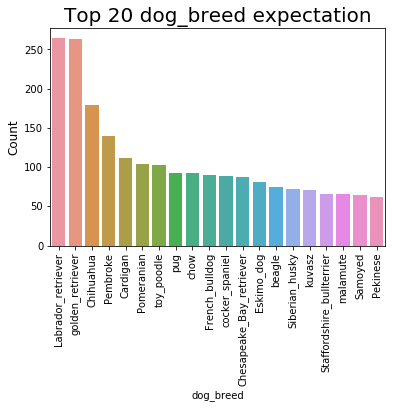

In [89]:
# Plot
dog_breed_plot = sns.barplot(x = 'dog_breed', y = 'total', data = top_20)

# Set title
dog_breed_plot.set_title('Top 20 dog_breed expectation', fontsize = 20)

# x-label
dog_breed_plot.set_ylabel('Count', fontsize = 12)

# Rotate to see the breed name well
plt.xticks(rotation = 90)

## 2) Let's see the tweeted hour distribution and average score('rating_numerator') of them

Text(0,0.5,'Count')

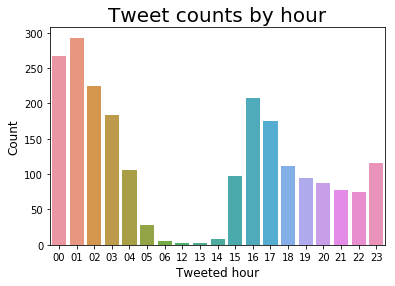

In [90]:
# Let's distribute all tweets by tweeted hour
merged_tweets['tweeted_hour'] = merged_tweets.timestamp.str[11:13]

# Make a sub DataFrame to make a plot
time_df = merged_tweets.tweeted_hour.value_counts()
time_df = pd.DataFrame(data = time_df)

# Plot
time_plot = sns.barplot(x = time_df.index, y = time_df.tweeted_hour)

# Set title
time_plot.set_title('Tweet counts by hour', fontsize = 20)

# x-label
time_plot.set_xlabel('Tweeted hour', fontsize = 12)

# y-label
time_plot.set_ylabel('Count', fontsize = 12)

- We can see that from midnight to  before 3 o'clock is the time that many of tweets are made.
- From 7 o'clock to before noon, not even one tweets are created.

Text(0,0.5,'rating_numerator')

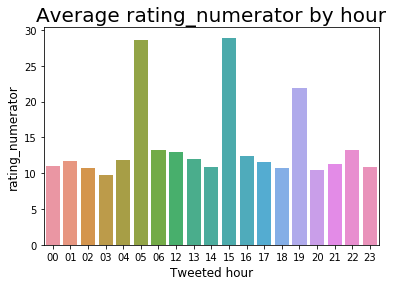

In [91]:
# Make a average score('rating_numerator') per hour
grouped = merged_tweets.groupby('tweeted_hour')
time_mean = grouped['rating_numerator'].agg(np.mean)

# Converto DataFrame
time_mean = pd.DataFrame(data = time_mean)

# Plot
time_mean_plot = sns.barplot(x = time_mean.index, y = time_mean.rating_numerator)

# Set title
time_mean_plot.set_title('Average rating_numerator by hour', fontsize = 20)

# x-label
time_mean_plot.set_xlabel('Tweeted hour', fontsize = 12)

# y-label
time_mean_plot.set_ylabel('rating_numerator', fontsize = 12)


- Except for 05-06, 15-16, 19-20, o'clock, numbers looks quite similar, all under 15
- 05, 15, 19 are noticeable. But in 'Tweet counts by hour' graph, these are 15th, 10th, 11th. I thnk few anomaly might caused this.

In [92]:
# Check if there is an anomaly or not, from 5 o'clock to  6 o'clock
merged_tweets[merged_tweets['tweeted_hour'] == '05']['rating_numerator'].value_counts()

10.0     8
9.0      3
8.0      3
12.0     3
7.0      2
11.0     2
3.0      1
4.0      1
420.0    1
13.0     1
144.0    1
9.5      1
5.0      1
Name: rating_numerator, dtype: int64

Rating_numerator 420, 144 seem to be anomalies out of 28 counts.

In [93]:
# Check if there is an anomaly or not, from 15 o'clock to  16 o'clock
merged_tweets[merged_tweets['tweeted_hour'] == '15']['rating_numerator'].value_counts()

11.0      21
12.0      20
10.0      16
13.0      12
9.0        9
14.0       7
7.0        4
4.0        2
10.5       1
8.0        1
6.0        1
1776.0     1
3.0        1
0.0        1
Name: rating_numerator, dtype: int64

Rating_numerator 1776 seems to be an anomaly out of 97 counts.

In [94]:
# Check if there is an anomaly or not, from 19 o'clock to 20 o'clock
merged_tweets[merged_tweets['tweeted_hour'] == '19']['rating_numerator'].value_counts()

10.0     23
12.0     21
11.0     20
13.0     10
8.0       7
9.0       7
6.0       2
2.0       1
14.0      1
666.0     1
420.0     1
Name: rating_numerator, dtype: int64

Rating_numerator 666, 420 seem to be anomalies out of 94 counts.

In [95]:
# Let's see top 20 rating_numerators
merged_tweets.rating_numerator.sort_values(ascending = False).head(20)

799     1776.0
162      666.0
1881     420.0
161      420.0
934      204.0
245      182.0
729      165.0
1588     144.0
1445     143.0
1446     121.0
1041      99.0
1652      88.0
361       84.0
1066      80.0
1162      60.0
1086      45.0
1244      44.0
1473      20.0
246       15.0
75        14.0
Name: rating_numerator, dtype: float64

Text(0,0.5,'rating_numerator')

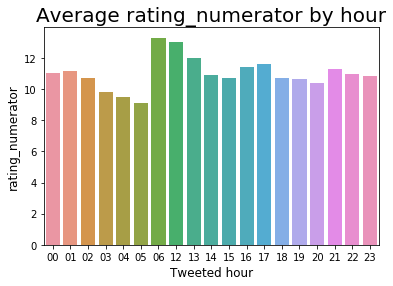

In [96]:
# Let's plot excluded tweets that 'rating_numerator' > 100
merged_tweets1 = merged_tweets[merged_tweets['rating_numerator'] <= 100]

# Make a average score('rating_numerator') per hour
grouped = merged_tweets1.groupby('tweeted_hour')
time_mean = grouped['rating_numerator'].agg(np.mean)

# Converto DataFrame
time_mean = pd.DataFrame(data = time_mean)

# Plot
time_mean_plot = sns.barplot(x = time_mean.index, y = time_mean.rating_numerator)

# Set title
time_mean_plot.set_title('Average rating_numerator by hour', fontsize = 20)

# x-label
time_mean_plot.set_xlabel('Tweeted hour', fontsize = 12)

# y-label
time_mean_plot.set_ylabel('rating_numerator', fontsize = 12)

Yes, without anomalies, except time 7 o'clock to 12 o'clock, avereage 'rating_numerator' more seems evenly distributed.

# 3) Relationship between 'favorite_count',  'retweet_count', and 'meaningful_score'

[(0, 130000)]

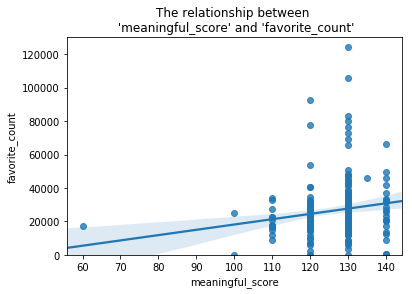

In [97]:
# Let's see the relationship between 'favorite_count' and 'meaningful_score'
merged_tweets['meaningful_score'] = (merged_tweets['rating_numerator'] / merged_tweets['rating_denominator']) * 100

# Select only 'favorite_count' in not null
merged_tweetsmerged_tweets = merged_tweets[merged_tweets['favorite_count'].notnull()]
merged_tweets = merged_tweets[merged_tweets['meaningful_score'] < 4000] # To avoid anomalies


score_plot = sns.regplot(x = 'meaningful_score', y = 'favorite_count', data = merged_tweets)
plt.title("The relationship between \n 'meaningful_score' and 'favorite_count'")


score_plot.set(ylim=(0, 130000))
# fig =score_plot.get_figure()

In [98]:
merged_tweets[['meaningful_score', 'favorite_count']].corr()

,meaningful_score,favorite_count
meaningful_score,1.000000,0.170052
favorite_count,0.170052,1.000000


Text(0.5,1,"The relationship between \n 'meaningful_score' and 'retweet_count'")

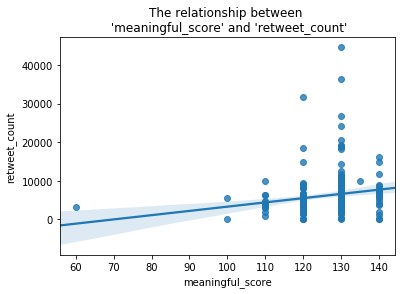

In [99]:
score_plot = sns.regplot(x = 'meaningful_score', y = 'retweet_count', data = merged_tweets)
plt.title("The relationship between \n 'meaningful_score' and 'retweet_count'")

As above graph and correlation efficient show, 'meaningful_score' and 'favorite_count' are not related much.

In [100]:
merged_tweets[['meaningful_score', 'retweet_count']].corr()

,meaningful_score,retweet_count
meaningful_score,1.000000,0.178417
retweet_count,0.178417,1.000000


The relatioinship between 'meaningful_score' and 'retweet_count' is as well.

Text(0.5,1,"The relationship between \n 'retweet_count' and 'favorite_count'")

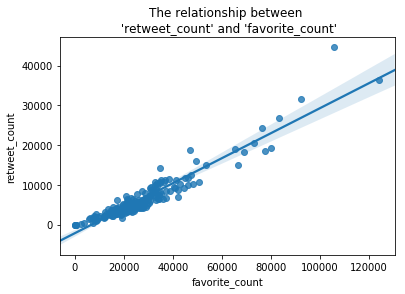

In [101]:
favorite_retweet_plot = sns.regplot(x = 'favorite_count', y = 'retweet_count', data = merged_tweets)
plt.title("The relationship between \n 'retweet_count' and 'favorite_count'")

In [102]:
merged_tweets[['favorite_count', 'retweet_count']].corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.948009
retweet_count,0.948009,1.000000


Only the correlation efficient(0.948005) between 'favorite_count' and 'retweet_count' is meaningful.

They are in a strongly positive relationship.

# 5. Storing wrangled data
Produce 'merged_tweets' as a csv file.

In [103]:
merged_tweets.to_csv('master_dataset.csv', index = False)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2034
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          87
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11